In [142]:
import pandas as pd
import numpy as np

#df = pd.read_csv(r"C:\Users\kavya\Desktop\Kavya\Intelihub\client\HERC\Latest\data\model_ready_2.csv")

In [143]:
df = pd.read_csv(r"C:\Users\HP\Documents\Load_Forecasting_using_Fbprophet\Final Files fbprophet\Combined_Data_for_model_final_2.csv")

In [144]:
del df['Unnamed: 0']

#### Adding Covid Lockdown Column and Extracting Cal Features

In [145]:
df['Date'] = pd.to_datetime(df['Date'])

In [146]:
df = df[df['Date']>='2018-01-01']

In [147]:
df['Covid_Lockdown'] = (df['Date']>='2020-03-01') & (df['Date'] <= '2020-04-30')

In [148]:
df['Covid_Lockdown'] = df['Covid_Lockdown'].astype(int)

In [149]:
df

,Date,Haryana Load (MW),temp,dew,humidity,windspeed,winddir,cloudcover,visibility,Covid_Lockdown
70175,2018-01-01 00:00:00,3880.22,11.0,9.0,87.48,0.0,0.0,0.0,1.0,0
70176,2018-01-01 00:15:00,3778.15,11.0,9.0,87.48,0.0,0.0,0.0,1.0,0
70177,2018-01-01 00:30:00,3742.81,11.0,9.0,87.48,0.0,0.0,0.0,1.0,0
70178,2018-01-01 00:45:00,3627.39,11.0,9.0,87.48,0.0,0.0,0.0,1.0,0
70179,2018-01-01 01:00:00,3616.50,10.0,8.0,87.38,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...
210426,2021-12-31 22:45:00,4712.55,10.0,8.0,87.38,0.0,0.0,27.4,2.0,0
210427,2021-12-31 23:00:00,4649.58,9.2,7.3,88.04,0.0,0.0,28.5,1.3,0
210428,2021-12-31 23:15:00,4571.39,9.2,7.3,88.04,0.0,0.0,28.5,1.3,0
210429,2021-12-31 23:30:00,4510.39,9.2,7.3,88.04,0.0,0.0,28.5,1.3,0


In [150]:
df['month'] = pd.to_datetime(df['Date']).dt.month
df['weekday'] = pd.to_datetime(df['Date']).dt.weekday
df['hour'] = pd.to_datetime(df['Date']).dt.hour
df['hour_part'] = pd.to_datetime(df['Date']).dt.minute
df['year'] = pd.to_datetime(df['Date']).dt.year
df['day'] = pd.to_datetime(df['Date']).dt.day

# remove outliers in windspeed - checked the max windspeed India recorded - it is around 100
df = df[df['windspeed']<=100]

<AxesSubplot:>

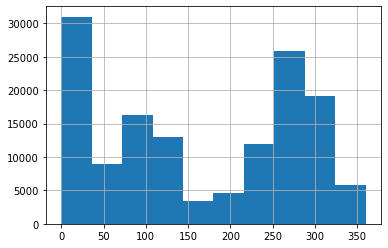

In [151]:
df['winddir'].hist()

In [152]:
def get_season(TimeSeries):
    
    season_list = []
    
    year_list = []
    month_list = []
    for time in TimeSeries:
        year = str(time)[:4]
        month = str(time)[5:7]
        year_list.append(year)
        month_list.append(month) 
       
    for m in month_list:
        if m=='01' or m=='02' or m=='12':
            season_list.append(0)   # Winter
        elif m=='03' or m=='04' or m=='05':
            season_list.append(1) #Spring-Summer
        elif m == '06' or m=='07':
            season_list.append(2) #Paddy/Monsoon
        elif m=='08' or m=='09':
            season_list.append(3) #Late Monsoon
        elif m=='10' or m=='11':
            season_list.append(4) #Autumn
            
    #season = pd.Series(season_list)
    return season_list

In [153]:
season = get_season(df['Date'])

In [154]:
df['Season'] = season

C:\Users\HP\AppData\Local\Temp/ipykernel_14944/3332413871.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Season'] = season


In [155]:
from sklearn import metrics
import numpy as np
from sklearn.model_selection import StratifiedKFold
import itertools
# from skopt import BayesSearchCV as bayes_opt

In [156]:
# check for 0 values and remove
df = df[df['Haryana Load (MW)']>0]

### Feature Selection

In [157]:
df

,Date,Haryana Load (MW),temp,dew,humidity,windspeed,winddir,cloudcover,visibility,Covid_Lockdown,month,weekday,hour,hour_part,year,day,Season
70175,2018-01-01 00:00:00,3880.22,11.0,9.0,87.48,0.0,0.0,0.0,1.0,0,1,0,0,0,2018,1,0
70176,2018-01-01 00:15:00,3778.15,11.0,9.0,87.48,0.0,0.0,0.0,1.0,0,1,0,0,15,2018,1,0
70177,2018-01-01 00:30:00,3742.81,11.0,9.0,87.48,0.0,0.0,0.0,1.0,0,1,0,0,30,2018,1,0
70178,2018-01-01 00:45:00,3627.39,11.0,9.0,87.48,0.0,0.0,0.0,1.0,0,1,0,0,45,2018,1,0
70179,2018-01-01 01:00:00,3616.50,10.0,8.0,87.38,0.0,0.0,0.0,1.0,0,1,0,1,0,2018,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210426,2021-12-31 22:45:00,4712.55,10.0,8.0,87.38,0.0,0.0,27.4,2.0,0,12,4,22,45,2021,31,0
210427,2021-12-31 23:00:00,4649.58,9.2,7.3,88.04,0.0,0.0,28.5,1.3,0,12,4,23,0,2021,31,0
210428,2021-12-31 23:15:00,4571.39,9.2,7.3,88.04,0.0,0.0,28.5,1.3,0,12,4,23,15,2021,31,0
210429,2021-12-31 23:30:00,4510.39,9.2,7.3,88.04,0.0,0.0,28.5,1.3,0,12,4,23,30,2021,31,0


In [158]:
df.corr()

,Haryana Load (MW),temp,dew,humidity,windspeed,winddir,cloudcover,visibility,Covid_Lockdown,month,weekday,hour,hour_part,year,day,Season
Haryana Load (MW),1.000000,5.288371e-01,6.237437e-01,-1.231803e-02,9.933357e-02,-1.216974e-02,2.752580e-01,2.967968e-01,-0.295794,1.887023e-01,-4.519345e-02,9.216813e-02,1.294208e-03,5.699700e-02,2.200230e-03,3.082654e-01
temp,0.528837,1.000000e+00,5.475659e-01,-5.964366e-01,3.692731e-01,1.317399e-01,2.351072e-01,6.941409e-01,-0.011139,5.521950e-02,-8.515858e-03,2.124607e-01,4.156862e-16,-3.130122e-02,-8.186022e-03,3.666333e-01
dew,0.623744,5.475659e-01,1.000000e+00,3.073087e-01,9.084371e-02,-1.563891e-01,5.550333e-01,3.024795e-01,-0.080891,2.464792e-01,3.955586e-03,-1.634162e-02,9.365413e-16,3.364062e-02,-3.176907e-02,5.123812e-01
humidity,-0.012318,-5.964366e-01,3.073087e-01,1.000000e+00,-3.255844e-01,-2.936104e-01,2.846371e-01,-5.095855e-01,-0.077536,1.512545e-01,1.164118e-02,-2.813678e-01,4.208840e-16,7.728681e-02,-4.273287e-03,4.282657e-02
windspeed,0.099334,3.692731e-01,9.084371e-02,-3.255844e-01,1.000000e+00,4.777698e-01,1.883089e-01,3.219970e-01,0.018506,-1.764341e-01,3.103804e-02,1.485372e-01,-7.598375e-16,-6.908740e-02,1.448248e-02,-8.350912e-02
winddir,-0.012170,1.317399e-01,-1.563891e-01,-2.936104e-01,4.777698e-01,1.000000e+00,-1.008212e-01,1.100025e-01,0.023799,-1.120618e-01,8.472648e-03,1.294449e-01,-5.967361e-16,-5.557366e-02,3.040546e-02,-1.022130e-01
cloudcover,0.275258,2.351072e-01,5.550333e-01,2.846371e-01,1.883089e-01,-1.008212e-01,1.000000e+00,9.877261e-02,0.015549,3.709965e-02,-1.182945e-02,1.904381e-02,6.300970e-16,5.856604e-02,4.619060e-03,1.331951e-01
visibility,0.296797,6.941409e-01,3.024795e-01,-5.095855e-01,3.219970e-01,1.100025e-01,9.877261e-02,1.000000e+00,0.058386,-1.078739e-02,-7.866041e-04,2.024846e-01,3.575802e-17,-2.612003e-02,2.345689e-02,2.237888e-01
Covid_Lockdown,-0.295794,-1.113899e-02,-8.089137e-02,-7.753600e-02,1.850550e-02,2.379883e-02,1.554886e-02,5.838636e-02,1.000000,-1.824135e-01,-4.812426e-03,-6.181520e-05,-4.819930e-05,9.251384e-02,-4.954853e-03,-1.100706e-01
month,0.188702,5.521950e-02,2.464792e-01,1.512545e-01,-1.764341e-01,-1.120618e-01,3.709965e-02,-1.078739e-02,-0.182414,1.000000e+00,-7.018813e-04,-7.535309e-06,1.807792e-15,-4.295780e-04,1.050419e-02,6.122413e-01


In [159]:
# Train Data
train = df[df['Date']<="2021-06-01"]

In [160]:
# Test Data
test = df[df['Date']>"2021-06-01"]

In [161]:
df = df[['Haryana Load (MW)', 'temp', 'dew', 'cloudcover', 'visibility', 'Covid_Lockdown', 'month', 'Season', 'hour']]

### One hot encoder

In [162]:
df = df.join(pd.get_dummies(df['Covid_Lockdown'], prefix = 'Covid_lockdown'))

In [163]:
df.drop(columns='Covid_Lockdown', inplace=True)

In [164]:
df = df.join(pd.get_dummies(df['month'], prefix = 'month'))
df.drop(columns='month', inplace=True)
df

,Haryana Load (MW),temp,dew,cloudcover,visibility,Season,hour,Covid_lockdown_0,Covid_lockdown_1,month_1,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
70175,3880.22,11.0,9.0,0.0,1.0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
70176,3778.15,11.0,9.0,0.0,1.0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
70177,3742.81,11.0,9.0,0.0,1.0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
70178,3627.39,11.0,9.0,0.0,1.0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
70179,3616.50,10.0,8.0,0.0,1.0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210426,4712.55,10.0,8.0,27.4,2.0,0,22,1,0,0,...,0,0,0,0,0,0,0,0,0,1
210427,4649.58,9.2,7.3,28.5,1.3,0,23,1,0,0,...,0,0,0,0,0,0,0,0,0,1
210428,4571.39,9.2,7.3,28.5,1.3,0,23,1,0,0,...,0,0,0,0,0,0,0,0,0,1
210429,4510.39,9.2,7.3,28.5,1.3,0,23,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [165]:
df = df.join(pd.get_dummies(df['Season'], prefix='Season'))

In [166]:
df.drop(columns='Season', inplace=True)
df

,Haryana Load (MW),temp,dew,cloudcover,visibility,hour,Covid_lockdown_0,Covid_lockdown_1,month_1,month_2,...,month_8,month_9,month_10,month_11,month_12,Season_0,Season_1,Season_2,Season_3,Season_4
70175,3880.22,11.0,9.0,0.0,1.0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
70176,3778.15,11.0,9.0,0.0,1.0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
70177,3742.81,11.0,9.0,0.0,1.0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
70178,3627.39,11.0,9.0,0.0,1.0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
70179,3616.50,10.0,8.0,0.0,1.0,1,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210426,4712.55,10.0,8.0,27.4,2.0,22,1,0,0,0,...,0,0,0,0,1,1,0,0,0,0
210427,4649.58,9.2,7.3,28.5,1.3,23,1,0,0,0,...,0,0,0,0,1,1,0,0,0,0
210428,4571.39,9.2,7.3,28.5,1.3,23,1,0,0,0,...,0,0,0,0,1,1,0,0,0,0
210429,4510.39,9.2,7.3,28.5,1.3,23,1,0,0,0,...,0,0,0,0,1,1,0,0,0,0


In [179]:
df

,Haryana Load (MW),temp,dew,cloudcover,visibility,hour,Covid_lockdown_0,Covid_lockdown_1,month_1,month_2,...,month_8,month_9,month_10,month_11,month_12,Season_0,Season_1,Season_2,Season_3,Season_4
70175,3880.22,11.0,9.0,0.0,1.0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
70176,3778.15,11.0,9.0,0.0,1.0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
70177,3742.81,11.0,9.0,0.0,1.0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
70178,3627.39,11.0,9.0,0.0,1.0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
70179,3616.50,10.0,8.0,0.0,1.0,1,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210426,4712.55,10.0,8.0,27.4,2.0,22,1,0,0,0,...,0,0,0,0,1,1,0,0,0,0
210427,4649.58,9.2,7.3,28.5,1.3,23,1,0,0,0,...,0,0,0,0,1,1,0,0,0,0
210428,4571.39,9.2,7.3,28.5,1.3,23,1,0,0,0,...,0,0,0,0,1,1,0,0,0,0
210429,4510.39,9.2,7.3,28.5,1.3,23,1,0,0,0,...,0,0,0,0,1,1,0,0,0,0


#### Train-test split

In [180]:
train = df[:int(df.shape[0]*0.8)]

In [181]:
train

,Haryana Load (MW),temp,dew,cloudcover,visibility,hour,Covid_lockdown_0,Covid_lockdown_1,month_1,month_2,...,month_8,month_9,month_10,month_11,month_12,Season_0,Season_1,Season_2,Season_3,Season_4
70175,3880.22,11.0,9.0,0.0,1.0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
70176,3778.15,11.0,9.0,0.0,1.0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
70177,3742.81,11.0,9.0,0.0,1.0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
70178,3627.39,11.0,9.0,0.0,1.0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
70179,3616.50,10.0,8.0,0.0,1.0,1,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182375,5108.20,27.6,14.5,0.0,4.0,18,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
182376,4908.75,27.6,14.5,0.0,4.0,18,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
182377,4918.90,27.6,14.5,0.0,4.0,18,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
182378,5063.31,27.6,14.5,0.0,4.0,18,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [182]:
test = df[int(df.shape[0]*0.8):]

In [183]:
test

,Haryana Load (MW),temp,dew,cloudcover,visibility,hour,Covid_lockdown_0,Covid_lockdown_1,month_1,month_2,...,month_8,month_9,month_10,month_11,month_12,Season_0,Season_1,Season_2,Season_3,Season_4
182380,5190.72,26.0,12.0,0.0,3.0,19,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
182381,5125.32,26.0,12.0,0.0,3.0,19,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
182382,5060.31,26.0,12.0,0.0,3.0,19,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
182383,4955.60,24.4,15.2,0.0,2.3,20,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
182384,4819.50,24.4,15.2,0.0,2.3,20,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210426,4712.55,10.0,8.0,27.4,2.0,22,1,0,0,0,...,0,0,0,0,1,1,0,0,0,0
210427,4649.58,9.2,7.3,28.5,1.3,23,1,0,0,0,...,0,0,0,0,1,1,0,0,0,0
210428,4571.39,9.2,7.3,28.5,1.3,23,1,0,0,0,...,0,0,0,0,1,1,0,0,0,0
210429,4510.39,9.2,7.3,28.5,1.3,23,1,0,0,0,...,0,0,0,0,1,1,0,0,0,0


In [184]:
y_train = train[['Haryana Load (MW)']]

In [185]:
y_test = test[['Haryana Load (MW)']]

In [186]:
x_train = train.drop(columns='Haryana Load (MW)')

In [187]:
x_test = test.drop(columns='Haryana Load (MW)')

In [188]:
x_test

,temp,dew,cloudcover,visibility,hour,Covid_lockdown_0,Covid_lockdown_1,month_1,month_2,month_3,...,month_8,month_9,month_10,month_11,month_12,Season_0,Season_1,Season_2,Season_3,Season_4
182380,26.0,12.0,0.0,3.0,19,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
182381,26.0,12.0,0.0,3.0,19,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
182382,26.0,12.0,0.0,3.0,19,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
182383,24.4,15.2,0.0,2.3,20,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
182384,24.4,15.2,0.0,2.3,20,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210426,10.0,8.0,27.4,2.0,22,1,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
210427,9.2,7.3,28.5,1.3,23,1,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
210428,9.2,7.3,28.5,1.3,23,1,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
210429,9.2,7.3,28.5,1.3,23,1,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0


In [189]:
x_test.describe()

,temp,dew,cloudcover,visibility,hour,Covid_lockdown_0,Covid_lockdown_1,month_1,month_2,month_3,...,month_8,month_9,month_10,month_11,month_12,Season_0,Season_1,Season_2,Season_3,Season_4
count,28051.000000,28051.000000,28051.000000,28051.000000,28051.000000,28051.0,28051.0,28051.0,28051.0,28051.000000,...,28051.000000,28051.000000,28051.000000,28051.000000,28051.000000,28051.000000,28051.000000,28051.000000,28051.000000,28051.000000
mean,27.024120,18.085459,40.222295,2.900667,11.506506,1.0,0.0,0.0,0.0,0.058857,...,0.106092,0.102670,0.106092,0.102670,0.106092,0.106092,0.267620,0.208763,0.208763,0.208763
std,6.793637,7.425792,35.212510,1.082558,6.924568,0.0,0.0,0.0,0.0,0.235361,...,0.307961,0.303533,0.307961,0.303533,0.307961,0.307961,0.442726,0.406432,0.406432,0.406432
min,5.000000,-6.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,12.300000,0.000000,2.000000,6.000000,1.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,28.000000,18.100000,46.000000,3.000000,12.000000,1.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,32.000000,25.000000,74.400000,4.000000,18.000000,1.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,43.000000,30.000000,100.000000,9.000000,23.000000,1.0,0.0,0.0,0.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [190]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [191]:
model = xgb.XGBRegressor()
model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [192]:
preds = model.predict(x_test)

In [193]:
y_test['pred'] = preds

C:\Users\HP\AppData\Local\Temp/ipykernel_14944/2190438978.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['pred'] = preds


In [194]:
from sklearn.metrics import r2_score
r2_score(y_test['Haryana Load (MW)'],y_test['pred'])

0.658501500828045

In [195]:
from sklearn.ensemble import RandomForestRegressor

In [196]:
regr = RandomForestRegressor()

In [197]:
regr.fit(x_train, y_train)

C:\Users\HP\AppData\Local\Temp/ipykernel_14944/1990009532.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(x_train, y_train)


RandomForestRegressor()

In [198]:
preds = model.predict(x_test)

In [199]:
y_test['pred'] = preds

C:\Users\HP\AppData\Local\Temp/ipykernel_14944/2190438978.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['pred'] = preds


In [200]:
from sklearn.metrics import r2_score
r2_score(y_test['Haryana Load (MW)'],y_test['pred'])

0.658501500828045

In [204]:
y_test

,Haryana Load (MW),pred
182380,5190.72,5811.823730
182381,5125.32,5811.823730
182382,5060.31,5811.823730
182383,4955.60,5730.580078
182384,4819.50,5730.580078
...,...,...
210426,4712.55,4724.169434
210427,4649.58,4541.874512
210428,4571.39,4541.874512
210429,4510.39,4541.874512


#### Bucket Analysis

In [207]:
train_predictions = model.predict(x_train)

In [208]:
train_predictions

array([4226.7637, 4226.7637, 4226.7637, ..., 5616.2007, 5616.2007,
       5811.8237], dtype=float32)

In [213]:
len(train_predictions)

112201

In [215]:
y_train = y_train.reset_index().drop(columns='index')

In [216]:
y_train_with_error = y_train.join(pd.Series(train_predictions, name='preds'))

In [217]:
y_train_with_error

,Haryana Load (MW),preds
0,3880.22,4226.763672
1,3778.15,4226.763672
2,3742.81,4226.763672
3,3627.39,4226.763672
4,3616.50,4212.666504
...,...,...
112196,5108.20,5616.200684
112197,4908.75,5616.200684
112198,4918.90,5616.200684
112199,5063.31,5616.200684


In [218]:
y_train_with_error['Error'] = y_train_with_error['Haryana Load (MW)'] - y_train_with_error['preds']

In [220]:
y_train_with_error['Percent Error'] = y_train_with_error['Error']*100/y_train_with_error['Haryana Load (MW)']

In [221]:
y_train_with_error

,Haryana Load (MW),preds,Error,Percent Error
0,3880.22,4226.763672,-346.543672,-8.931032
1,3778.15,4226.763672,-448.613672,-11.873898
2,3742.81,4226.763672,-483.953672,-12.930223
3,3627.39,4226.763672,-599.373672,-16.523552
4,3616.50,4212.666504,-596.166504,-16.484626
...,...,...,...,...
112196,5108.20,5616.200684,-508.000684,-9.944808
112197,4908.75,5616.200684,-707.450684,-14.412033
112198,4918.90,5616.200684,-697.300684,-14.175948
112199,5063.31,5616.200684,-552.890684,-10.919550


In [222]:
y_errorful_buckets = y_train_with_error[np.abs(y_train_with_error['Percent Error']) > 20]

In [223]:
y_errorful_buckets

,Haryana Load (MW),preds,Error,Percent Error
53,4250.75,5244.206055,-993.456055,-23.371312
64,4173.24,5024.524414,-851.284414,-20.398645
69,4610.39,5583.899902,-973.509902,-21.115565
607,4048.44,5481.911621,-1433.471621,-35.408000
608,3786.18,5445.031250,-1658.851250,-43.813322
...,...,...,...,...
111534,4692.67,5731.036133,-1038.366133,-22.127406
111535,4615.38,5731.036133,-1115.656133,-24.172574
111828,6254.97,4773.085449,1481.884551,23.691313
111829,6110.45,4773.085449,1337.364551,21.886515


In [225]:
x_train = x_train.reset_index().drop(columns='index')

In [226]:
x_train

,temp,dew,cloudcover,visibility,hour,Covid_lockdown_0,Covid_lockdown_1,month_1,month_2,month_3,...,month_8,month_9,month_10,month_11,month_12,Season_0,Season_1,Season_2,Season_3,Season_4
0,11.0,9.0,0.0,1.0,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,11.0,9.0,0.0,1.0,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,11.0,9.0,0.0,1.0,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,11.0,9.0,0.0,1.0,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,10.0,8.0,0.0,1.0,1,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112196,27.6,14.5,0.0,4.0,18,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
112197,27.6,14.5,0.0,4.0,18,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
112198,27.6,14.5,0.0,4.0,18,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
112199,27.6,14.5,0.0,4.0,18,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [227]:
y_errorful_buckets.index

Int64Index([    53,     64,     69,    607,    608,    609,    610,    611,
               612,    613,
            ...
            111307, 111308, 111309, 111522, 111533, 111534, 111535, 111828,
            111829, 111924],
           dtype='int64', length=5247)

In [228]:
x_train_new = x_train.drop(index = y_errorful_buckets.index)

In [229]:
x_train_new

,temp,dew,cloudcover,visibility,hour,Covid_lockdown_0,Covid_lockdown_1,month_1,month_2,month_3,...,month_8,month_9,month_10,month_11,month_12,Season_0,Season_1,Season_2,Season_3,Season_4
0,11.0,9.0,0.0,1.0,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,11.0,9.0,0.0,1.0,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,11.0,9.0,0.0,1.0,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,11.0,9.0,0.0,1.0,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,10.0,8.0,0.0,1.0,1,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112196,27.6,14.5,0.0,4.0,18,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
112197,27.6,14.5,0.0,4.0,18,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
112198,27.6,14.5,0.0,4.0,18,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
112199,27.6,14.5,0.0,4.0,18,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [230]:
y_train_new = y_train.drop(index = y_errorful_buckets.index)

In [231]:
model2 = xgb.XGBRFRegressor()

In [232]:
model2.fit(x_train_new, y_train_new)

XGBRFRegressor(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bytree=1,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
               importance_type=None, interaction_constraints='', max_bin=256,
               max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=0, num_parallel_tree=100,
               objective='reg:squarederror', predictor='auto', random_state=0,
               reg_alpha=0, sampling_method='uniform', scale_pos_weight=1, ...)

In [233]:
preds2 = model2.predict(x_test)

In [234]:
preds2

array([5581.7183, 5581.7183, 5581.7183, ..., 4825.6475, 4825.6475,
       4825.6475], dtype=float32)

In [235]:
from sklearn.metrics import r2_score
r2_score(y_test['Haryana Load (MW)'], preds2)

0.6684418421117722

#### Inputs for CV

In [202]:
# X.to_csv('X_for_ncv.csv')
# Y.to_csv('Y_for_ncv.csv')